In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

Link: https://medium.com/analytics-vidhya/python-symbolic-regression-with-gplearn-cbc24dbbc271
        
Link: https://iagml.github.io/notebooks/symbolic_regression.html        

In [2]:
nsample = 1000
sig = 0.2

In [3]:
def Hz(z):
    return z**2 + z**3 

In [18]:
rng = check_random_state(0)
z = rng.uniform(0, 10, nsample)
print(len(z))
H = Hz(z) + sig*np.random.normal(size=nsample)

1000


In [5]:
data = np.array([z, H]).T
columns = ['z', 'H (z)']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,z,H (z)
0,5.488135,195.498256
1,7.151894,417.007129
2,6.027634,255.344801
3,5.448832,191.820520
4,4.236548,93.864788


Text(0.5, 0, '$z$')

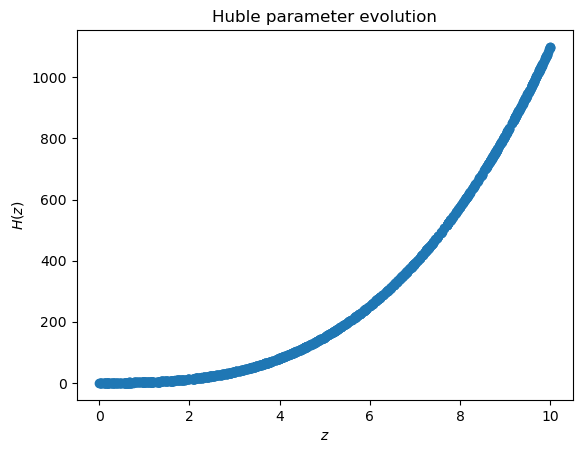

In [6]:
plt.figure(dpi = 100)
plt.title('Huble parameter evolution')
plt.scatter(df['z'], df['H (z)'])
plt.ylabel(r'$H (z)$')
plt.xlabel(r'$z$')

In [7]:
X = df[['z']]
y = df['H (z)']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 1), (300, 1), (700,), (300,))

In [8]:
function_set = ['add', 'log', 'mul']


In [9]:
est_gp = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

In [10]:
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.36      3.00551e+11       78          5.49506          5.23918      1.02m
   1    32.77          1760.84       15          2.02768          2.39786      1.00m
   2    33.52          1880.09       12          0.19734         0.215427     58.10s
   3    26.27          1765.52       13         0.161452          0.19973     45.54s
   4    18.24          1067.41       13         0.163283         0.183255     35.89s
   5    14.43          1213.38        9         0.159931         0.211198     31.65s
   6    11.44          702.351        9         0.159808         0.212302     26.04s
   7     8.45          1098.73        7         0.160244          0.20838     22.52s
   8     7.14           877.23        7         0.159773         0.212621  

In [11]:
t0 = time.time()
y_gp1 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.0006999969482421875 seconds


In [12]:
score_gp1 = est_gp.score(X_test, y_test)
print('R2:', score_gp1)

R2: 0.999999573947163


In [13]:
converter = {
    'add': lambda x, y : x + y,
    'sub': lambda x, y : x - y,
    'mul': lambda x, y : x*y,
    'div': lambda x, y : x/y,
    'sqrt': lambda x : x**0.5,
    'log': lambda x : log(x),
    'abs': lambda x : abs(x),
    'neg': lambda x : -x,
    'inv': lambda x : 1/x,
    'max': lambda x, y : max(x, y),
    'min': lambda x, y : min(x, y),
    'sin': lambda x : sin(x),
    'cos': lambda x : cos(x),
    'pow': lambda x, y : x**y,
}

In [14]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

X0*(X0**2 + X0)

In [15]:
y_gp = est_gp.predict(X_test)
score_gp1 = est_gp.score(X_test, y_test)
score_gp1

0.999999573947163

Text(0.5, 0, 'z')

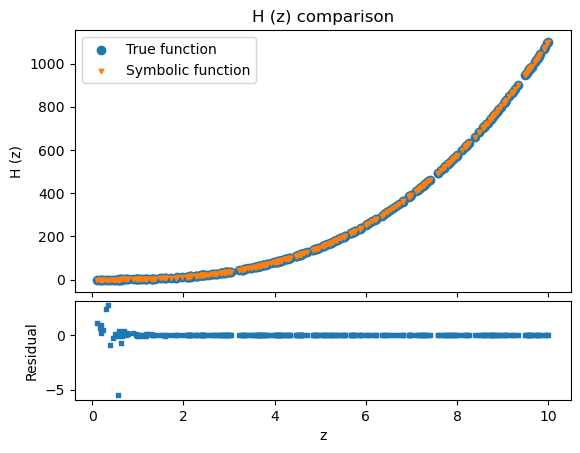

In [16]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_gp1, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_gp1/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')